<a href="https://colab.research.google.com/github/jprve/MS-Floorplan/blob/main/MS_ProgressiveGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.utils.data as data

from PIL import Image

import os
import matplotlib.pyplot as plt

# Import packages

In [16]:
# Training Params
batch_size = 16
image_size = 64
num_epochs = 50
latent_dim = 128


# RGB Output
output_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Configuration of Transformer
transform = transforms.Compose([
    transforms.CenterCrop(148),
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [17]:
# Discriminator Implementation

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Generator Implementation

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


# Progressive GAN Implementation

class ProgressiveGAN(nn.Module):
    def __init__(self, resolution, num_channels=3, latent_dim=100):
        super(ProgressiveGAN, self).__init__()
        self.resolution = resolution
        self.num_channels = num_channels
        self.latent_dim = latent_dim
        self.current_scale = 2
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

    def update_resolution(self, resolution):
        self.resolution = resolution
        self.current_scale = int(2 ** (torch.log2(torch.tensor(resolution)).item() - 1))

    def get_generator(self):
        return self.generator

    def get_discriminator(self):
        return self.discriminator

In [18]:
class FloorDataset(data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(root)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.image_files[index])
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image

In [19]:
transform = transforms.Compose([
    transforms.ToTensor()])

dataset = FloorDataset(root='/content/drive/MyDrive/jpm', transform=transform) # Load dataset from Google Drive
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Progressive GAN params

resolution = 4
image_size = 64
num_channels = 3
latent_dim = 100
batch_size = 512
learning_rate = 0.0002

progressive_gan = ProgressiveGAN(resolution, num_channels, latent_dim)
generator = progressive_gan.get_generator().to(device)
discriminator = progressive_gan.get_discriminator().to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
# Plot images on grid to preview before running

def plot_images(imgs, grid_size = 5):
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

dataset.__getitem__(5).shape

# View shape of dataset

In [26]:
criterion = nn.BCELoss()
real_label = 1
fake_label = 0


# Define optimizers

optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# The Training loop

num_epochs = 51
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Run Progressive GAN if needed
        if progressive_gan.resolution > image_size:
            progressive_gan.update_resolution(image_size)
            generator = progressive_gan.get_generator()
            discriminator = progressive_gan.get_discriminator()

        real_images= data
        real_images = real_images.to(device)

        # Generate Fake Images

        fake_images = generator(torch.randn(real_images.size(0), latent_dim, 1, 1).to(device))

        # Update Discriminator

        optimizerD.zero_grad()

        # Train with Real Images

        label = torch.full((real_images.size(0),), real_label, device=device)
        output = discriminator(real_images).view(-1)
        errD_real = criterion(output, label.float())  # Convert label to Float
        errD_real.backward()
        D_x = output.mean().item()

        # Train with Fake Images

        label.fill_(fake_label)
        output = discriminator(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label.float())  # Convert label to Float
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update the generator

        optimizerG.zero_grad()

        label.fill_(real_label)  # Update labels to real_label for generator update
        output = discriminator(fake_images).view(-1)
        errG = criterion(output, label.float())  # Convert label to Float
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print Epoch Stats

        if i % 1000 == 0:
            print('[Epoch {}/{}][Batch {}/{}] Loss_D: {:.4f} Loss_G: {:.4f} D(x): {:.4f} D(G(z)): {:.4f}/{:.4f}'
                  .format(epoch, num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save generated images

        if epoch % 10 == 0:
            torchvision.utils.save_image(fake_images.detach(), 'epoch_{}.png'.format(epoch), normalize=True)
            torch.save(generator.state_dict(), 'generator_epoch_{}.pth'.format(epoch))
            torch.save(discriminator.state_dict(), 'discriminator_epoch_{}.pth'.format(epoch))

[Epoch 0/51][Batch 0/163] Loss_D: 2.2886 Loss_G: 0.3193 D(x): 0.2630 D(G(z)): 0.0199/0.8492
[Epoch 1/51][Batch 0/163] Loss_D: 0.7529 Loss_G: 2.9638 D(x): 0.8762 D(G(z)): 0.3516/0.0767
[Epoch 2/51][Batch 0/163] Loss_D: 0.7851 Loss_G: 2.6970 D(x): 0.6657 D(G(z)): 0.0497/0.1138
[Epoch 3/51][Batch 0/163] Loss_D: 1.5366 Loss_G: 1.4748 D(x): 0.3485 D(G(z)): 0.0611/0.2544
[Epoch 4/51][Batch 0/163] Loss_D: 1.4931 Loss_G: 1.9073 D(x): 0.5716 D(G(z)): 0.0648/0.1969
[Epoch 5/51][Batch 0/163] Loss_D: 0.6812 Loss_G: 1.7828 D(x): 0.7131 D(G(z)): 0.1319/0.1927
[Epoch 6/51][Batch 0/163] Loss_D: 0.3713 Loss_G: 2.6153 D(x): 0.8400 D(G(z)): 0.0905/0.0850
[Epoch 7/51][Batch 0/163] Loss_D: 0.4570 Loss_G: 2.7693 D(x): 0.7701 D(G(z)): 0.0678/0.0661
[Epoch 8/51][Batch 0/163] Loss_D: 0.5105 Loss_G: 3.2640 D(x): 0.9269 D(G(z)): 0.2973/0.0491
[Epoch 9/51][Batch 0/163] Loss_D: 10.6695 Loss_G: 5.4310 D(x): 1.0000 D(G(z)): 1.0000/0.0046
[Epoch 10/51][Batch 0/163] Loss_D: 0.8544 Loss_G: 2.0745 D(x): 0.6883 D(G(z)): 

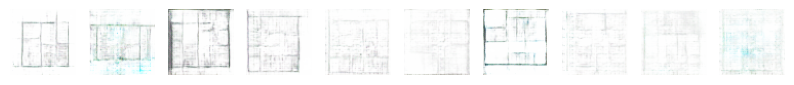

In [25]:
# View output from model after 50 epochs
import matplotlib.pyplot as plt

generator.eval()  # set to evaluation mode
discriminator.eval()  # set to evaluation mode


# Generate fake images

num_fake_images = 10
fake_images = generator(torch.randn(num_fake_images, latent_dim, 1, 1).to(device))

# Denormalize fake images

fake_images = fake_images * 0.5 + 0.5
fake_images = fake_images.cpu().detach().numpy()

fig, axes = plt.subplots(1, num_fake_images, figsize=(10, 5))  # create subplots of fake images

for i in range(num_fake_images):
    fake_image = fake_images[i].transpose(1, 2, 0)  # transpose to (H, W, C) format
    axes[i].imshow(fake_image)
    axes[i].axis('off')

plt.show()